# TABLE OF CONTENTS

* [1. INTRODUCTION](#section-one)
* [2. SETUP](#section-two)
    - [2.1 Draw Packages](#subsection-two-one)
    - [2.2 Import/Wrangle Data](#subsection-two-two)
    - [2.3 Generate the portfolio formation dates for our sample (Key idea #1)](#subsection-two-three)
* [3. TESTING OVERREACTION HYPOTHESIS](#section-three)
    - [3.1 Question 1: How do we construct portfolios?](#subsection-three-one)
        - [3.1.1 Constructing portfolios on a single date (1 instance)](#subsection-three-one-one)
        - [3.1.2 Constructing portfolios on each date (N instance) with a function (Key idea #2)](#subsection-three-one-two)
    - [3.2 Question 2: How do we calculate holding period returns?](#subsection-three-two)
        - [3.2.1 Constructing holding period returns on a single portfolio/date (1 instance)](#subsection-three-two-one)
        - [3.2.2 Constructing holding period returns on each portfolio/date (N instance) with a function (Key idea #3)](#subsection-three-two-two)
    - [3.3 Question 3: Do current losers beat current winners in the future?](#subsection-three-three)
* [4. CONCLUSION](#section-four)
* [5. PROBLEM SET 1: QUESTION 2](#section-five)
* [6. REFERENCES](#section-six)

Reminder: The dataset is for the use of this class only. Please do not share it beyond the classroom.

<a id="section-one"></a>
# 1. INTRODUCTION

## Team members
### Lucas Sebastian A0112080B
### Sekson Ounsaengchan (Beer) A0227885M
### Zhao Mengyu (Jessica) A0227914B

## De Bondt and Thaler (1985)

In the seminal paper, "Does the stock market overreact?" De Bondt and Thaler (1985) discover significant evidence of weak-form market inefficiencies. 

## Objective

- Test for the overreaction hypothesis in financial markets based on 
  [De Bondt and Thaler (1985), Does the Stock Market Overreact?,
  Journal of Finance](http://onlinelibrary.wiley.com/doi/10.1111/j.1540-6261.1985.tb05004.x/full).
- Get similar results to Figure 3 in the paper.

## Motivation

- "Research in experimental psychology has suggested that, in violation of Bayes' rule, most people tend to "overreact" to unexpected and dramatic news events." ~ De Bondt and Thaler (1985)
- Does such behavior matter at the market level?
  
Note: Replication is imperfect, but in the spirit of the original paper. Empirical choices in data selection (number of observations required for portfolios, exchange types, etc.) and in portfolio performance evaluation (computing abnormal returns, forming portfolios, etc.) are different from the original paper. 


## Key Steps

The beauty in De Bondt and Thaler's empirical test of overreaction hypothesis is its simplicity. Specifically, what DeBondt and Thaler do is calculate portfolio returns for some formation period – i.e. previous 36-month performance – and then see how that particular portfolio performs in an evaluation period – i.e. subsequent 36-month performance. To test the overreaction hypothesis, De Bondt and Thaler form loser and winner portfolios composed of the 30 worst-performing and 30 best-performing stocks, respectively, over the formation period. They then follow these portfolios for the subsequent 36 months and evaluate and compare their performance. The key steps are summarized below:

1. Identify portfolio formation dates.
2. Identify winner and loser portfolios by ranking securities by past returns.
3. Track and calculate the holding period returns for each portfolio.

<a id="section-two"></a>
# 2. SETUP

<a id="subsection-two-one"></a>
## 2.1 Draw Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy import stats

%matplotlib inline

<a id="subsection-two-two"></a>
## 2.2 Import/Wrangle Data

This is a monthly stock-level return file. The data have been pre-screened to include only common stock (SHRCD 10 or 11) and listings on AMEX, NYSE or NASDAQ (EXCHCD 1, 2 or 3). 

In [2]:
local_path = "C:/Users/sekso/Desktop/MBA/sem4/Fintech/Bootcamp Codes and Data/03 Behavioral Finance/"
# df_crsp = pd.read_csv(local_path + 'monthly.csv')  # Load part of the file to have a look

df_crsp = pd.read_csv(local_path + "msf_200901-202012.csv")  # Load csv file into dataframe

C:\Users\sekso\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Permno is a unique stock/share class-level identifier.

In [3]:
df_crsp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1033173 entries, 0 to 1033172
Data columns (total 9 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   PERMNO  1033173 non-null  int64  
 1   date    1033173 non-null  int64  
 2   SICCD   1026989 non-null  object 
 3   PRC     1013647 non-null  float64
 4   RET     1021281 non-null  object 
 5   SHROUT  1026302 non-null  float64
 6   SPREAD  27865 non-null    float64
 7   vwretd  1033173 non-null  float64
 8   ewretd  1033173 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 70.9+ MB


 Panda treats DATE as an int64 object. We need DATE to be a datetime object, so we will parse the dates.

In [4]:
df_crsp.head()

,PERMNO,date,SICCD,PRC,RET,SHROUT,SPREAD,vwretd,ewretd
0,10001,20090130,4920.0,8.502,0.03414,4297.0,NaN,-0.077475,-0.024042
1,10001,20090227,4920.0,8.940,0.056222,4297.0,NaN,-0.100175,-0.107606
2,10001,20090331,4920.0,8.180,-0.080537,4300.0,NaN,0.086813,0.107474
3,10001,20090430,4920.0,8.500,0.044621,4300.0,NaN,0.109483,0.192762
4,10001,20090529,4920.0,8.480,0.002941,4354.0,NaN,0.067797,0.102330


Letters, such as `C`, identify special cases in this dataset. In this case, we ask pandas to treat `C` as a null value. Please delve into the dataset documentation carefully, so to make sure that what you do is reasonable. 

We are re-importing the dataset with date parsing (into datetime object) and ret correction (from "C" to a null value).

In [5]:
df_crsp = pd.read_csv(local_path + "msf_200901-202012.csv", na_values=["B", "C", "Z"], parse_dates=["date"])

# The output from WRDS returns a mixed of small and large cap column names. Let's standardize everything in small caps.
cols = df_crsp.columns
print(cols)
print(type(cols))

# List comprehension [expression for variable in iterable]
df_crsp.columns = [c.lower() for c in cols]

Index(['PERMNO', 'date', 'SICCD', 'PRC', 'RET', 'SHROUT', 'SPREAD', 'vwretd',
       'ewretd'],
      dtype='object')
<class 'pandas.core.indexes.base.Index'>


[HERE](http://www.learnbyexample.org/python-list-comprehension/) for more details on list comprehension

In [6]:
df_crsp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1033173 entries, 0 to 1033172
Data columns (total 9 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   permno  1033173 non-null  int64         
 1   date    1033173 non-null  datetime64[ns]
 2   siccd   1026803 non-null  float64       
 3   prc     1013647 non-null  float64       
 4   ret     1006985 non-null  float64       
 5   shrout  1026302 non-null  float64       
 6   spread  27865 non-null    float64       
 7   vwretd  1033173 non-null  float64       
 8   ewretd  1033173 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 70.9 MB


Now date variable name is in lowercase and of type datetime64.

In [7]:
df_crsp.head()

,permno,date,siccd,prc,ret,shrout,spread,vwretd,ewretd
0,10001,2009-01-30,4920.0,8.502,0.034140,4297.0,NaN,-0.077475,-0.024042
1,10001,2009-02-27,4920.0,8.940,0.056222,4297.0,NaN,-0.100175,-0.107606
2,10001,2009-03-31,4920.0,8.180,-0.080537,4300.0,NaN,0.086813,0.107474
3,10001,2009-04-30,4920.0,8.500,0.044621,4300.0,NaN,0.109483,0.192762
4,10001,2009-05-29,4920.0,8.480,0.002941,4354.0,NaN,0.067797,0.102330


Notice that "c" is now NaN (i.e., Not a Number) - this is Python's way of representing missing value.

Exploring the distributional characteristics of our variables.

In [8]:
df_crsp.describe()

,permno,siccd,prc,ret,shrout,spread,vwretd,ewretd
count,1.033173e+06,1.026803e+06,1.013647e+06,1.006985e+06,1.026302e+06,27865.000000,1.033173e+06,1.033173e+06
mean,6.038065e+04,5.818966e+03,5.950448e+01,1.215098e-02,9.756848e+04,0.578258,1.214390e-02,1.226344e-02
std,3.370057e+04,2.217899e+03,2.594325e+03,1.573849e-01,3.703394e+05,3.714150,4.422972e-02,5.223411e-02
min,1.000100e+04,0.000000e+00,-5.886000e+02,-9.936000e-01,2.000000e+00,0.000700,-1.417330e-01,-2.075010e-01
25%,1.670400e+04,3.840000e+03,7.620000e+00,-4.276600e-02,8.350000e+03,0.080000,-1.041000e-02,-1.138800e-02
50%,7.947200e+04,6.726000e+03,1.853000e+01,6.452000e-03,2.702300e+04,0.170000,1.426900e-02,1.073600e-02
75%,9.001200e+04,6.726000e+03,3.784000e+01,5.504200e-02,7.114600e+04,0.440000,3.751400e-02,3.888400e-02
max,9.343600e+04,9.999000e+03,3.478150e+05,1.988359e+01,2.920640e+07,475.000000,1.296770e-01,1.927620e-01


Notice that Prc (or Price) has 'negative' values. What is going on? The documentation says a dash prefixes the price when no closing price is available for that period and when the bid/ask average is used. We will take the absolute value of the price, which is sensible in most cases.

In [9]:
# Sanitize dataset

# Drop observations with missing returns
df_crsp = df_crsp[df_crsp.ret.notnull()]

# Take the absolute value of the price
df_crsp["prc"] = np.abs(df_crsp["prc"])

In [10]:
# Set the index (to select easily on date)
df_crsp = df_crsp.set_index("date")
df_crsp = df_crsp.sort_index()

[HERE](https://www.geeksforgeeks.org/python-pandas-dataframe-set_index/) for more details on on Pandas indexing.

In [11]:
# Compute continuously compounded returns (i.e. log returns).
df_crsp["lret"] = np.log(1 + df_crsp["ret"])
df_crsp["lvwretd"] = np.log(1 + df_crsp["vwretd"])
df_crsp["lewretd"] = np.log(1 + df_crsp["ewretd"])

# Compute the market cap
df_crsp["size"] = df_crsp["shrout"] * df_crsp["prc"]

** Why are continously compounded returns (i.e., log returns) useful?

In [12]:
df_crsp.head()
# df_crsp.tail()

,permno,siccd,prc,ret,shrout,spread,vwretd,ewretd,lret,lvwretd,lewretd,size
date,,,,,,,,,,,,
2009-01-30,10001,4920.0,8.502,0.034140,4297.0,NaN,-0.077475,-0.024042,0.033570,-0.080641,-0.024336,36533.094
2009-01-30,67467,5331.0,13.450,-0.071774,82117.0,NaN,-0.077475,-0.024042,-0.074480,-0.080641,-0.024336,1104473.650
2009-01-30,90565,4899.0,13.560,0.135678,68432.0,NaN,-0.077475,-0.024042,0.127230,-0.080641,-0.024336,927937.920
2009-01-30,92590,4841.0,18.350,0.049771,493269.0,NaN,-0.077475,-0.024042,0.048572,-0.080641,-0.024336,9051486.150
2009-01-30,84073,6331.0,28.040,-0.095977,37254.0,NaN,-0.077475,-0.024042,-0.100900,-0.080641,-0.024336,1044602.160


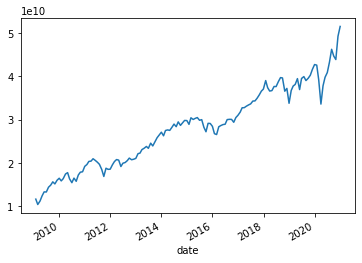

In [13]:
# Total market size over time

ax = df_crsp.groupby(["date"])["size"].sum().plot()

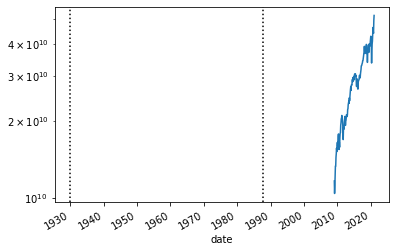

In [14]:
# Taking the log of market size
ax = df_crsp.groupby(["date"])["size"].sum().plot(logy=True)

# Add some informative lines
ax.axvline(x=datetime(1929, 10, 24), color="k", linestyle=":")  # Black Monday
ax.axvline(x=datetime(1987, 10, 19), color="k", linestyle=":")  # Black Monday again

Let's configure the parameters of our model.

<a id="subsection-two-three"></a>
## 2.3 Generate the portfolio formation dates for our sample (Key idea #1)

In [15]:
# Parameters
form_period = 36  # 36 Formation period, in month
start_date = "2012-01-01"
end_date = "2020-12-31"

In [16]:
# Get the dates of portfolio formation.
# The frequency tells how far apart to put the dates.
# 'M' stand for month, 'MS' is for month start, to make sure we
# have first day of the month. It needs to be a string, so we convert
# our numbers to string.
dates = pd.date_range(
    start=start_date, end=end_date, freq=str(np.int(form_period)) + "M"
)
dates

C:\Users\sekso\AppData\Local\Temp/ipykernel_21252/724698719.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  start=start_date, end=end_date, freq=str(np.int(form_period)) + "M"


DatetimeIndex(['2012-01-31', '2015-01-31', '2018-01-31'], dtype='datetime64[ns]', freq='36M')

[HERE](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases) for more details on the various options to tell how far apart to put the dates.  
[HERE](https://www.geeksforgeeks.org/python-pandas-date_range-method/) for more details on the date_range method in Pandas.

** Why do we need the dates of portfolio formation for?  
This datetime object is an essential input for the two core functions: the function that contructs loser/winner portfolios and the function that calculates holding period returns.

<a id="section-three"></a>
# 3. TESTING OVERREACTION HYPOTHESIS

<a id="subsection-three-one"></a>
## 3.1 Question 1: How do we construct portfolios?

For each portfolio formation date (listed in previous step), we are going to form portfolios based on past performance. Specifically, a stock's past performance is its cumulative return during the formation period before the formation date. Then, we will track the performance of the top and bottom performing portfolios, which we identify during the formation period, over the holding period.

<a id="subsection-three-one-one"></a>
## 3.1.1 Constructing portfolios on a single-date (1 instance)

Let's specify the model parameters for portfolio on a single-date (before we generalize later)

In [17]:
form_period = 36  # 36 Formation period, in month
n_stocks = 35  # Number of stocks in the top and bottom performance
benchmark = "ewretd"  # Benchmark market return to use ('vwretd' or 'ewretd')

In [18]:
# Let's first do it for only one date.
date = dates[0]
print(dates[0])

beg_dt = date - pd.offsets.MonthEnd(1) * form_period
print(beg_dt, date - pd.offsets.MonthEnd(1))
# Select obs for the formation period
# crsp_t = df_crsp[beg_dt:date].copy()
crsp_t = df_crsp[beg_dt : (date - pd.offsets.MonthEnd(1))].copy()

2012-01-31 00:00:00
2009-01-31 00:00:00 2011-12-31 00:00:00


[HERE](https://www.w3resource.com/pandas/series/series-dt-to_pydatetime.php) for more details on the to_pydatetime() method in Pandas.

In [19]:
crsp_t

,permno,siccd,prc,ret,shrout,spread,vwretd,ewretd,lret,lvwretd,lewretd,size
date,,,,,,,,,,,,
2009-02-27,80485,2830.0,4.03,-0.179226,69667.0,NaN,-0.100175,-0.107606,-0.197507,-0.105555,-0.113848,280758.01
2009-02-27,89403,4941.0,19.92,-0.081181,29385.0,NaN,-0.100175,-0.107606,-0.084666,-0.105555,-0.113848,585349.20
2009-02-27,92740,6726.0,15.20,-0.044326,200.0,4.0,-0.100175,-0.107606,-0.045338,-0.105555,-0.113848,3040.00
2009-02-27,88742,4813.0,21.15,-0.132486,23625.0,NaN,-0.100175,-0.107606,-0.142124,-0.105555,-0.113848,499668.75
2009-02-27,88820,6798.0,15.65,-0.288636,8299.0,NaN,-0.100175,-0.107606,-0.340571,-0.105555,-0.113848,129879.35
...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-30,92336,6726.0,108.23,0.017422,900.0,NaN,0.003671,-0.003561,0.017272,0.003664,-0.003567,97407.00
2011-12-30,81541,6035.0,17.10,0.007067,54664.0,NaN,0.003671,-0.003561,0.007042,0.003664,-0.003567,934754.40
2011-12-30,92490,6726.0,34.76,-0.033912,35400.0,NaN,0.003671,-0.003561,-0.034500,0.003664,-0.003567,1230504.00


In [20]:
# We only want to keep stocks that are there during the full formation window

crsp_t['N'] = crsp_t.groupby(['permno'])['permno'].transform('count')

# Filter on number of observations. We only keep sotcks for which we have returns
# over the full observation period.
crsp_t = crsp_t[crsp_t['N'] >= form_period]


[HERE](https://pbpython.com/pandas_transform.html) for more details on the transform method in Pandas.

In [21]:
# Now for each stock we want to compute the full period return.
stock_ret = crsp_t.groupby('permno')[['lret', 'lvwretd', 'lewretd']].sum()

In [22]:
stock_ret.head()

,lret,lvwretd,lewretd
permno,,,


In [23]:
# Next compute excess returns based on the chosen index.
# Note that since the benchmark is the same for all stocks, we could use
# actual returns for ranking purposes. It would only make a difference in some
### cases. Which ones?

stock_ret['lexret'] = stock_ret['lret'] - stock_ret['l' + benchmark]

In [24]:
# Now rankings.

stock_ret['rank_asc'] = stock_ret['lexret'].rank() # (1 = worst return)
stock_ret['rank_inv'] = stock_ret['lexret'].rank(ascending=False) # (1= best return)

In [25]:
stock_ret

,lret,lvwretd,lewretd,lexret,rank_asc,rank_inv
permno,,,,,,


** rank_asc + rank_inv should give us the total number of securities for a formation date, why is it not the case?

In [26]:
# Assign stock to top or bottom portfolio

top_portfolio = stock_ret[stock_ret.rank_inv <= n_stocks].reset_index()[['permno', 'lexret']]
bottom_portfolio = stock_ret[stock_ret.rank_asc <= n_stocks].reset_index()[['permno', 'lexret']]
    

** why do we set index on permno and log excess returns?

In [27]:
top_portfolio.head()

,permno,lexret


In [28]:
bottom_portfolio.head()

,permno,lexret


<a id="subsection-three-one-two"></a>
## 3.1.2 Constructing portfolios on each date (N instances) with a function (Key idea #2)

Now that we have the code working for one date, we need to run it on each date. Now it's time to generate generalize from 1 instance to N instances with a function.

In [29]:
def compute_performance_portfolios(
    date, df, form_period=36, n_stocks=35, benchmark="ewretd", partition="permno"
):
    """
    Function computes the performance portfolios, separated into bottom and top performing portfolios
    
    Parameters:
        date (np.datetime): The date at which to start looking
        df (pandas.DataFrame): dataframe source 
        form_period (int): the number of months used to lookback and form the portfolio
        n_stocks (int): the number of stocks to form the portfolio 
        benchmark (str): the benchmark used, either value weighted or equal weighted. See column name in df
        partition (str): type of partition to be used
    Returns:
        tuple: tuple containing the bottom and top portfolios
    """
    beg_dt = (
        date - pd.offsets.MonthEnd(1) * form_period
    )  # find 36months before the first date
    end_dt = date - pd.offsets.MonthEnd(1)
    # Select obs for the formation period
    crsp_t = df[beg_dt:end_dt].copy()
    # We only want to keep stocks that are there during the full formation window
    crsp_t["N"] = crsp_t.groupby([partition])[partition].transform("count")
    max_form = max(crsp_t["N"])

    # Filter on number of observations. We only keep stocks for which we have returns
    # over the full observation period.
    crsp_t = crsp_t[crsp_t["N"] >= form_period]
    if len(crsp_t) == 0:
        end_dt = date + pd.offsets.MonthBegin(1)
        crsp_t = df[beg_dt:end_dt].copy()
        crsp_t["N"] = crsp_t.groupby([partition])[partition].transform("count")
        crsp_t = crsp_t[crsp_t["N"] >= form_period]

    # Now for each stock we want to compute the full period return. Easy with log returns, just sum up!
    stock_ret = crsp_t.groupby(partition)[["lret", "lvwretd", "lewretd"]].sum()

    # Next compute excess returns based on the chosen index.
    # Note that since the benchmark is the same for all stocks, we could use
    # actual returns for ranking purposes.
    stock_ret["lexret"] = stock_ret["lret"] - stock_ret["l" + benchmark]

    # Now rankings.
    stock_ret["rank_asc"] = stock_ret["lexret"].rank()  # (1 = worst return)
    stock_ret["rank_inv"] = stock_ret["lexret"].rank(
        ascending=False
    )  # (1= best return)

    # Assign stock to top or bottom portfolio
    top_portfolio = stock_ret[stock_ret.rank_inv <= n_stocks].reset_index()[
        [partition, "lexret"]
    ]
    bottom_portfolio = stock_ret[stock_ret.rank_asc <= n_stocks].reset_index()[
        [partition, "lexret"]
    ]

    return (bottom_portfolio, top_portfolio)

** What do the arguments date, df, form_period, n_stocks, and benchmark contain?  
** What object type does the function returns with "(bottom_portfolio, top_portfolio)"?

[HERE](http://https://www.w3schools.com/python/python_tuples.asp) for more details on Python Tuple.

In [30]:
portfolios = {}
for date in dates:
    portfolios[date] = compute_performance_portfolios(date, df_crsp, benchmark="ewretd")

** What is this line of code "portfolios = {}" for?  
** What does dictionary "portfolios contain?  
** What is the key of the dictionary "portfolios?  
** What are the values that each key in the dictionary "portfolios?

In [31]:
type(portfolios)

dict

In [32]:
portfolios.keys()

dict_keys([Timestamp('2012-01-31 00:00:00', freq='36M'), Timestamp('2015-01-31 00:00:00', freq='36M'), Timestamp('2018-01-31 00:00:00', freq='36M')])

Check out the values associated with each dictionary key with "portfolios.values()" -- Warning long output, but useful to understand the data structure

In [33]:
portfolios[date][0].head()

,permno,lexret
0,11182,-4.299902
1,12500,-10.819978
2,12579,-4.543111
3,13013,-8.155369
4,13030,-7.517432


In [34]:
portfolios[date][1].head()

,permno,lexret
0,10966,1.816982
1,12226,1.484895
2,12339,1.572539
3,12497,1.453154
4,13933,1.590277


<a id="subsection-three-two"></a>
## 3.2 Question 2: How do we construct holding period returns?

Next, we want to compute cumulative abnormal returns for portfolios during the holding period. First, we do it for one portfolio/date, then we generalize it with a function for each portfolio/date.

<a id="subsection-three-two-one"></a>
## 3.2.1 Constructing portfolios on a single portfolio/date (1 instance)

In [35]:
date = dates[0]
portfolio = portfolios[date][0] # Bottom portfolio.

hold_period = 36 # Holding period, in months
benchmark = 'ewretd' # 'vwretd' or 'ewretd'
weighting = 'ew' # 'vw' or 'ew'


In [36]:
portfolio = portfolio.copy()
end_dt = date + pd.offsets.MonthBegin(1) * hold_period

# Select obs for the formation period
crsp_t2 = df_crsp[date:end_dt].copy()

** To get end_dt, why do we add, instead of minus (like before), pd.offsets.MonthBegin(1) * hold_period?  
** Why is it "crsp_t2 = df_crsp[date:end_dt].copy()" instead of "crsp_t = df_crsp[beg_dt:date].copy()" now?  

In [37]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   permno  35 non-null     int64  
 1   lexret  35 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 688.0 bytes


In [38]:
crsp_t2

,permno,siccd,prc,ret,shrout,spread,vwretd,ewretd,lret,lvwretd,lewretd,size
date,,,,,,,,,,,,
2012-01-31,12856,6726.0,21.162,0.067171,50.0,NaN,0.054140,0.085342,0.065011,0.052725,0.081895,1058.10
2012-01-31,79689,3820.0,1.920,0.043478,20594.0,NaN,0.054140,0.085342,0.042559,0.052725,0.081895,39540.48
2012-01-31,13017,6726.0,80.465,0.008965,100.0,0.29,0.054140,0.085342,0.008925,0.052725,0.081895,8046.50
2012-01-31,93283,6726.0,38.890,-0.317000,350.0,NaN,0.054140,0.085342,-0.381260,0.052725,0.081895,13611.50
2012-01-31,77776,6726.0,22.000,0.072647,22782.0,NaN,0.054140,0.085342,0.070129,0.052725,0.081895,501204.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31,52396,3714.0,19.790,0.102097,26630.0,NaN,-0.003661,-0.000181,0.097215,-0.003668,-0.000181,527007.70
2014-12-31,51423,7011.0,18.510,0.124544,18662.0,NaN,-0.003661,-0.000181,0.117378,-0.003668,-0.000181,345433.62
2014-12-31,89428,6022.0,57.080,-0.079948,1216670.0,NaN,-0.003661,-0.000181,-0.083325,-0.003668,-0.000181,69447523.60


In [39]:
# Merge with stocks in portfolios, to keep only those stocks
crsp_t2 = pd.merge(crsp_t2.reset_index(), portfolio, on=['permno'])

In [40]:
crsp_t2

,date,permno,siccd,prc,ret,shrout,spread,vwretd,ewretd,lret,lvwretd,lewretd,size,lexret
0,2012-01-31,92813,6726.0,29.9000,-0.199357,38582.0,NaN,0.054140,0.085342,-0.222340,0.052725,0.081895,1.153602e+06,-5.168006
1,2012-02-29,92813,6726.0,25.5200,-0.146488,36232.0,NaN,0.041253,0.036494,-0.158396,0.040425,0.035844,9.246406e+05,-5.168006
2,2012-03-30,92813,6726.0,20.6500,-0.190831,37082.0,NaN,0.024039,0.017608,-0.211747,0.023755,0.017455,7.657433e+05,-5.168006
3,2012-04-30,92813,6726.0,21.1800,0.025666,32681.0,NaN,-0.006840,-0.009106,0.025342,-0.006864,-0.009148,6.921836e+05,-5.168006
4,2012-05-31,92813,6726.0,27.0100,0.275260,25581.0,NaN,-0.065641,-0.068418,0.243150,-0.067895,-0.070871,6.909428e+05,-5.168006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874,2014-02-28,90743,4412.0,0.6476,-0.405872,48318.0,NaN,0.046225,0.044257,-0.520660,0.045188,0.043306,3.129074e+04,-3.592272
875,2014-03-31,90743,4412.0,1.6000,-0.752934,9388.0,NaN,0.004544,0.001028,-1.398100,0.004534,0.001027,1.502080e+04,-3.592272
876,2014-04-30,90743,4412.0,0.1100,-0.931250,71999.0,NaN,0.001569,-0.022319,-2.677279,0.001568,-0.022572,7.919890e+03,-3.592272
877,2014-05-30,90743,4412.0,1.3800,-0.749091,21139.0,NaN,0.020260,0.006647,-1.382665,0.020057,0.006625,2.917182e+04,-3.592272


** What was the index for crsp_t2 before reset_index()? What is the index now?  
** Why has the number of observations gone down from 25011 to 1262?

In [41]:
crsp_t2.head()

,date,permno,siccd,prc,ret,shrout,spread,vwretd,ewretd,lret,lvwretd,lewretd,size,lexret
0,2012-01-31,92813,6726.0,29.90,-0.199357,38582.0,NaN,0.054140,0.085342,-0.222340,0.052725,0.081895,1153601.80,-5.168006
1,2012-02-29,92813,6726.0,25.52,-0.146488,36232.0,NaN,0.041253,0.036494,-0.158396,0.040425,0.035844,924640.64,-5.168006
2,2012-03-30,92813,6726.0,20.65,-0.190831,37082.0,NaN,0.024039,0.017608,-0.211747,0.023755,0.017455,765743.30,-5.168006
3,2012-04-30,92813,6726.0,21.18,0.025666,32681.0,NaN,-0.006840,-0.009106,0.025342,-0.006864,-0.009148,692183.58,-5.168006
4,2012-05-31,92813,6726.0,27.01,0.275260,25581.0,NaN,-0.065641,-0.068418,0.243150,-0.067895,-0.070871,690942.81,-5.168006


In [42]:
crsp_t2.tail()

,date,permno,siccd,prc,ret,shrout,spread,vwretd,ewretd,lret,lvwretd,lewretd,size,lexret
874,2014-02-28,90743,4412.0,0.6476,-0.405872,48318.0,NaN,0.046225,0.044257,-0.520660,0.045188,0.043306,31290.7368,-3.592272
875,2014-03-31,90743,4412.0,1.6000,-0.752934,9388.0,NaN,0.004544,0.001028,-1.398100,0.004534,0.001027,15020.8000,-3.592272
876,2014-04-30,90743,4412.0,0.1100,-0.931250,71999.0,NaN,0.001569,-0.022319,-2.677279,0.001568,-0.022572,7919.8900,-3.592272
877,2014-05-30,90743,4412.0,1.3800,-0.749091,21139.0,NaN,0.020260,0.006647,-1.382665,0.020057,0.006625,29171.8200,-3.592272
878,2014-06-30,90743,4412.0,0.2500,-0.818841,144550.0,NaN,0.027991,0.039501,-1.708380,0.027606,0.038741,36137.5000,-3.592272


In [43]:
# We want to make sure we have one observation for each stock/date.
# If a stock is delisted, its returns will be 0 after it disappears,
# so we just fill in these missing values.

# The idea here is to create a DataFrame with all the permno/date pairs
# that we want in the final dataset. Then we merge that list with the
# dataset using "outer" which will generate missing values for the
# pairs that are not in the dataset.

# Get the dates in the dataset.
pairs_t2 = [{'date': d, 'permno': p} for d in crsp_t2['date'].unique() 
                                    for p in portfolio['permno'].unique()]
print(pairs_t2[:10])
print(type(pairs_t2))
print(type(pairs_t2[0]))
print(len(portfolio))

[{'date': numpy.datetime64('2012-01-31T00:00:00.000000000'), 'permno': 11018}, {'date': numpy.datetime64('2012-01-31T00:00:00.000000000'), 'permno': 32636}, {'date': numpy.datetime64('2012-01-31T00:00:00.000000000'), 'permno': 59483}, {'date': numpy.datetime64('2012-01-31T00:00:00.000000000'), 'permno': 77437}, {'date': numpy.datetime64('2012-01-31T00:00:00.000000000'), 'permno': 80625}, {'date': numpy.datetime64('2012-01-31T00:00:00.000000000'), 'permno': 83551}, {'date': numpy.datetime64('2012-01-31T00:00:00.000000000'), 'permno': 85047}, {'date': numpy.datetime64('2012-01-31T00:00:00.000000000'), 'permno': 88945}, {'date': numpy.datetime64('2012-01-31T00:00:00.000000000'), 'permno': 89030}, {'date': numpy.datetime64('2012-01-31T00:00:00.000000000'), 'permno': 89452}]
<class 'list'>
<class 'dict'>
35


** What is the implication of filling in missing returns with 0?

In [44]:
pairs_t2 = pd.DataFrame(pairs_t2)
pairs_t2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1260 non-null   datetime64[ns]
 1   permno  1260 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 19.8 KB


In [45]:
# Merge to generate placeholders

crsp_t2 = pd.merge(crsp_t2, pairs_t2, how='outer', on=['permno', 'date'])
crsp_t2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1260 entries, 0 to 1259
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     1260 non-null   datetime64[ns]
 1   permno   1260 non-null   int64         
 2   siccd    879 non-null    float64       
 3   prc      879 non-null    float64       
 4   ret      879 non-null    float64       
 5   shrout   879 non-null    float64       
 6   spread   17 non-null     float64       
 7   vwretd   879 non-null    float64       
 8   ewretd   879 non-null    float64       
 9   lret     879 non-null    float64       
 10  lvwretd  879 non-null    float64       
 11  lewretd  879 non-null    float64       
 12  size     879 non-null    float64       
 13  lexret   879 non-null    float64       
dtypes: datetime64[ns](1), float64(12), int64(1)
memory usage: 147.7 KB


In [46]:
# Fill missing values with 0
ret_cols = ['ret', 'vwretd', 'ewretd', 'lvwretd','lewretd', 'lret', 'lexret']
crsp_t2[ret_cols] = crsp_t2[ret_cols].fillna(0.0)

In [47]:
# Now we want the return up to each point in time
crsp_t2['lcumret'] = crsp_t2.groupby('permno')['lret'].cumsum()
crsp_t2['lcum' + benchmark] = crsp_t2.groupby('permno')['l' + benchmark].cumsum()

In [48]:
# At each point in time, the return of the portfolio will be the 
# cumulative return of each component weighted by the initial weight.
# Note that here we need the average (equally- or value-weighted) cumulative return
# So, we need to back out the cumulative return from its log form.

crsp_t2['cumret'] = np.exp(crsp_t2['lcumret']) - 1
crsp_t2['cum' + benchmark] = np.exp(crsp_t2['lcum' + benchmark]) - 1

# Add weights, equal weighted is easy.
portfolio['ew'] = 1 / len(portfolio)

# For value-weighted, need to get size as of formation date.
portfolio['date'] = date
weights = pd.merge_asof(portfolio, df_crsp[['permno', 'size']],
                        by='permno',
                        left_on='date',
                        right_index=True)
weights['vw'] = weights['size'] / weights['size'].sum()

del weights['lexret']
del weights['date']
del weights['size']

In [49]:
weights.head()

,permno,ew,vw
0,11018,0.028571,0.121159
1,32636,0.028571,0.010233
2,59483,0.028571,0.016185
3,77437,0.028571,0.004308
4,80625,0.028571,0.054940


In [50]:
# Now merge back with returns
crsp_t2 = pd.merge(crsp_t2, weights, on='permno')

In [51]:
crsp_t2.head()

,date,permno,siccd,prc,ret,shrout,spread,vwretd,ewretd,lret,lvwretd,lewretd,size,lexret,lcumret,lcumewretd,cumret,cumewretd,ew,vw
0,2012-01-31,92813,6726.0,29.90,-0.199357,38582.0,NaN,0.054140,0.085342,-0.222340,0.052725,0.081895,1153601.80,-5.168006,-0.222340,0.081895,-0.199357,0.085342,0.028571,0.21938
1,2012-02-29,92813,6726.0,25.52,-0.146488,36232.0,NaN,0.041253,0.036494,-0.158396,0.040425,0.035844,924640.64,-5.168006,-0.380736,0.117739,-0.316642,0.124950,0.028571,0.21938
2,2012-03-30,92813,6726.0,20.65,-0.190831,37082.0,NaN,0.024039,0.017608,-0.211747,0.023755,0.017455,765743.30,-5.168006,-0.592483,0.135194,-0.447048,0.144759,0.028571,0.21938
3,2012-04-30,92813,6726.0,21.18,0.025666,32681.0,NaN,-0.006840,-0.009106,0.025342,-0.006864,-0.009148,692183.58,-5.168006,-0.567141,0.126046,-0.432855,0.134334,0.028571,0.21938
4,2012-05-31,92813,6726.0,27.01,0.275260,25581.0,NaN,-0.065641,-0.068418,0.243150,-0.067895,-0.070871,690942.81,-5.168006,-0.323991,0.055175,-0.276743,0.056726,0.028571,0.21938


In [52]:
# Now compute the weighted cumulative return: equally- or value-weighted
crsp_t2['wcumret'] = crsp_t2[weighting] * crsp_t2['cumret']
crsp_t2['wcum' + benchmark] = crsp_t2[weighting] * crsp_t2['cum' + benchmark]

portfolio_ret = crsp_t2.groupby(['date'])[['wcumret', 'wcum' + benchmark]].sum()

In [53]:
# Count the months
portfolio_ret = portfolio_ret.reset_index()
portfolio_ret['months'] = portfolio_ret.index.values + 1

In [54]:
portfolio_ret['exret'] = portfolio_ret['wcumret'] - portfolio_ret['wcum' + benchmark]

In [55]:
portfolio_ret.head()

,date,wcumret,wcumewretd,months,exret
0,2012-01-31,0.176296,0.085342,1,0.090954
1,2012-02-29,0.336930,0.122687,2,0.214243
2,2012-03-30,0.487541,0.140797,3,0.346744
3,2012-04-30,0.515147,0.131862,4,0.383284
4,2012-05-31,0.366925,0.067558,5,0.299367


<a id="subsection-three-two-two"></a>
## 3.2.2 Computing holding period returns on each portfolio/date (N instances) with a function (Key idea #3)

Now that we have the code working for one portfolio/date to compute cumulative abnormal returns for portfolios during the holding period, we will generalize it to run on each portfolio/date with a function.

In [56]:
def compute_holding_returns(date, portfolio, df, benchmark='ewretd', weighting='ew',
                            hold_period=36, partition = "permno"):
    """
    Function computes the average returns of a given portoflio previously generated by compuete_performance_portfolio() 
    
    Parameters:
        date (np.datetime): The date at which to start looking
        portfolio (pandas.DataFrame): dataframe slice from compute_performance_portfolio()
        df (pandas.DataFrame): original dataframe source 
        benchmark (str): the benchmark used, either value weighted or equal weighted. See column name in df
        weighting (str): either value or equal weighted. 
        partition (str): type of partition to be used
    Returns:
        dataframe: portfolio returns 
    """
    
    port = portfolio.copy()
    end_dt = date + pd.offsets.MonthBegin(1) * hold_period
    # Select obs for the formation period
    crsp_t2 = df[date:end_dt].copy()
    # Merge with stocks in portfolios, to keep only those stocks
    crsp_t2 = pd.merge(crsp_t2.reset_index(), port, on=[partition])
    crsp_t2
    

    # Get the dates in the dataset.
    pairs_t2 = [{'date': d, partition: p} for d in crsp_t2['date'].unique() for p in port[partition].unique()]
    pairs_t2 = pd.DataFrame(pairs_t2)
    pairs_t2
    crsp_t2 = pd.merge(crsp_t2, pairs_t2, how='outer', on=[partition, 'date'])
    ret_cols = ['ret', 'vwretd', 'ewretd', 'lvwretd','lewretd', 'lret', 'lexret']
    crsp_t2[ret_cols] = crsp_t2[ret_cols].fillna(0.0)
    
    # Now we want the return up to each point in time
    crsp_t2['lcumret'] = crsp_t2.groupby(partition)['lret'].cumsum()
    crsp_t2['lcum' + benchmark] = crsp_t2.groupby(partition)['l' + benchmark].cumsum()

    # At each point in time, the return of the portfolio will be the 
    # cumulative return of each component weighted by the initial weight.
    # Note that here we need the simple return average, not log return.
    crsp_t2['cumret'] = np.exp(crsp_t2['lcumret']) - 1
    crsp_t2['cum' + benchmark] = np.exp(crsp_t2['lcum' + benchmark]) - 1

    # Add weights, equal weighted is easy.
    port['ew'] = 1 / len(port)

    # For value-weighted, need to get size as of formation date.
    port['date'] = date
    weights = pd.merge_asof(port, df[[partition, 'size']],
                            by=partition,
                            left_on='date',
                            right_index=True)
    weights['vw'] = weights['size'] / weights['size'].sum()

    del weights['lexret']
    del weights['date']
    del weights['size']
    
    # Now merge back with returns
    crsp_t2 = pd.merge(crsp_t2, weights, on=partition)
    
    # Now compute the weighted cumulative return 
    crsp_t2['wcumret'] = crsp_t2[weighting] * crsp_t2['cumret']
    crsp_t2['wcum' + benchmark] = crsp_t2[weighting] * crsp_t2['cum' + benchmark]

    portfolio_ret = crsp_t2.groupby(['date'])[['wcumret', 'wcum' + benchmark]].sum()
    
    # Count the months
    portfolio_ret = portfolio_ret.reset_index()
    portfolio_ret['months'] = portfolio_ret.index.values + 1
    
    portfolio_ret['exret'] = portfolio_ret['wcumret'] - portfolio_ret['wcum' + benchmark]
    
    return portfolio_ret

In [57]:
bottom_portfolio_ret = []
top_portfolio_ret = []

form_period = 36 # 36 Formation period, in month
n_stocks = 35  # Number of stocks in the top and bottom performance
hold_period = 36
benchmark = 'ewretd' # Benchmark market return to use ('vwretd' or 'ewretd')

for date in dates:
    bottom_portfolio_ret.append(compute_holding_returns(date, portfolios[date][0], df_crsp, benchmark='ewretd', weighting='ew', hold_period = hold_period))
    top_portfolio_ret.append(compute_holding_returns(date, portfolios[date][1], df_crsp, benchmark='ewretd', weighting='ew', hold_period = hold_period))

** Which data structures do both bottom_portfolio_ret and top_portfolio_ret belong to?

In [58]:
bottom_portfolio_ret
type(bottom_portfolio_ret)

list

Ops, we have a list of dataframes here. Let's join the dataframes together into a single dataframes.

In [59]:
bottom_portfolio_ret = pd.concat(bottom_portfolio_ret)
top_portfolio_ret = pd.concat(top_portfolio_ret)

In [60]:
bottom_portfolio_ret
#  type(bottom_portfolio_ret)

,date,wcumret,wcumewretd,months,exret
0,2012-01-31,0.176296,0.085342,1,0.090954
1,2012-02-29,0.336930,0.122687,2,0.214243
2,2012-03-30,0.487541,0.140797,3,0.346744
3,2012-04-30,0.515147,0.131862,4,0.383284
4,2012-05-31,0.366925,0.067558,5,0.299367
...,...,...,...,...,...
31,2020-08-31,0.613454,0.039283,32,0.574171
32,2020-09-30,0.619028,0.022407,33,0.596621
33,2020-10-30,0.557577,0.022758,34,0.534819
34,2020-11-30,0.406671,0.127467,35,0.279204


** Now which data structures do both bottom_portfolio_ret and top_portfolio_ret belong to?

Now, we have a nice monolithic dataframe.

We can write the above into a function

In [61]:
def get_portfolio_performance(dates, df, form_period=36, n_stocks=35,
                                   benchmark='ewretd', weighting = "ew", hold_period = 36, partition = "permno"):
    """
    Function computes the average returns of all portfolios formed from the form period, returns both the bottom and top portfolios
    
    Parameters:
        dates (list): List of dates for formation period
        df (pandas.DataFrame): original dataframe source 
        form_period (int): the number of months used to lookback and form the portfolio
        n_stocks (int): the number of stocks to form the portfolio 
        benchmark (str): the benchmark used, either value weighted or equal weighted. See column name in df
        weighting (str): either value or equal weighted. 
        hold_period (int): number of months to hold the portfolio 
        partition (str): type of partition to be used
    Returns:
        tuple: contains 2 dataframes, the bottom portfolio and top portfolio
    """
    portfolios = {}
    bottom_portfolio_ret = []
    top_portfolio_ret = []
    
    for date in dates:
        portfolios[date] = compute_performance_portfolios(date, df, form_period, n_stocks, benchmark, partition)
    
    for date in dates:
        bottom_portfolio_ret.append(compute_holding_returns(date, portfolios[date][0], df, benchmark, weighting, hold_period, partition))
        top_portfolio_ret.append(compute_holding_returns(date, portfolios[date][1], df, benchmark, weighting, hold_period, partition))
    
    bottom_portfolio_ret = pd.concat(bottom_portfolio_ret)
    top_portfolio_ret = pd.concat(top_portfolio_ret)
    
    return bottom_portfolio_ret, top_portfolio_ret

def plot_portfolio_performance(bottom_portfolio_ret, top_portfolio_ret, form_period, periodicity):
    grads = []
    i = periodicity
    while(i < form_period):
        grads.append(i)
        i += periodicity
        
    ax = bottom_portfolio_ret.groupby('months')['exret'].mean().plot(label='Past losers')
    top_portfolio_ret.groupby('months')['exret'].mean().plot(ax=ax, label='Past winners')
    ax.legend()
    ax.axhline(y=0,  color='black', alpha=0.5, linestyle=':')
    for grad in grads:
        ax.axvline(x=grad, color='black', alpha=0.5, linestyle='-')
        #ax.axvline(x=24, color='black', alpha=0.5, linestyle='-')
    return ax

<a id="subsection-three-three"></a>
## 3.3 Question 3: Do current losers beat current winners in the future?


<a id="subsection-three-one-one"></a>
### 3.1.1 Full sample 2009 - 2020

In [70]:
tset, pval = stats.ttest_1samp(top_portfolio_ret[top_portfolio_ret['months']==36].set_index('date')[:'2020']['exret'],0)

print('Mean Excess Return for Top Performing Funds ' + str(top_portfolio_ret[top_portfolio_ret['months']==36].set_index('date')[:'2020']['exret'].mean()))
print('P-values ' + str(pval))
if pval < 0.05:    # alpha value is 0.05 or 5%
    print(" we are rejecting null hypothesis")
else:
    print("we are accepting null hypothesis")

Mean Excess Return for Top Performing Funds 0.5916848930689392
P-values 0.13276748543257696
we are accepting null hypothesis


In [71]:
tset, pval = stats.ttest_1samp(bottom_portfolio_ret[bottom_portfolio_ret['months']==36].set_index('date')[:'2020']['exret'],0)

print('Mean Excess Return for Bottom Performing Funds ' + str(bottom_portfolio_ret[bottom_portfolio_ret['months']==36].set_index('date')[:'2020']['exret'].mean()))
print('P-values ' + str(pval))
if pval < 0.05:    # alpha value is 0.05 or 5%
    print(" we are rejecting null hypothesis")
else:
    print("we are accepting null hypothesis")

Mean Excess Return for Bottom Performing Funds -0.08967338991408844
P-values 0.8310861442984903
we are accepting null hypothesis


In [72]:
tset, pval = stats.ttest_ind(top_portfolio_ret[top_portfolio_ret['months']==36].set_index('date')[:'2020']['exret'],
                             bottom_portfolio_ret[bottom_portfolio_ret['months']==36].set_index('date')[:'2020']['exret'])

print('Mean Excess Return for Top Performing Funds ' + str(top_portfolio_ret[top_portfolio_ret['months']==36].set_index('date')[:'2020']['exret'].mean()))
print('Mean Excess Return for Bottom Performing Funds ' + str(bottom_portfolio_ret[bottom_portfolio_ret['months']==36].set_index('date')[:'2020']['exret'].mean()))
print('Mean Difference Bottom Minus Top in Excess Return ' + 
      str(bottom_portfolio_ret[bottom_portfolio_ret['months']==36].set_index('date')[:'2020']['exret'].mean() -                                                        
          top_portfolio_ret[top_portfolio_ret['months']==36].set_index('date')[:'2020']['exret'].mean()))
print('P-values ' + str(pval))
if pval < 0.05:    # alpha value is 0.05 or 5%
    print(" we are rejecting null hypothesis")
else:
    print("we are accepting null hypothesis")

Mean Excess Return for Top Performing Funds 0.5916848930689392
Mean Excess Return for Bottom Performing Funds -0.08967338991408844
Mean Difference Bottom Minus Top in Excess Return -0.6813582829830277
P-values 0.19331135067907332
we are accepting null hypothesis


We can again place the above into functions. 

In [68]:
def get_mean_excess_returns(portfolio, end_month, end_year = '1980'):
    """
    Function prints the mean excess returns of the portfolio, and checks if it deviates
    significantly from 0. 
    
    Paramters:
        portfolio (pandas.DataFrame): 1 of the either portfolios formed from get_portfolio_performance()
        end_month (int): the ending month (e.g 36 for the end of the portfolio)
        end_year (int): year at which to end the observation
    Returns:
        null 
    """
    tset, pval = stats.ttest_1samp(portfolio[portfolio['months'] == end_month].set_index('date')[:end_year]['exret'], 0)
    print("Mean Excess Return: " + str(portfolio[portfolio['months'] == end_month].set_index('date')[:end_year]['exret'].mean()))
    res = "Do Not Reject Null Hypothesis" if (pval < .05) else "Reject Null Hypothesis"
    print("P-Value: " + str(pval) + ", " + res)

def get_diff_excess_returns(portfolio1, portfolio2, end_month, end_year = '1980'):
    """
    Function prints the difference in excess returns of 2 portfolios, and checks if it deviates
    significantly from 0. 
    
    Paramters:
        portfolio1 (pandas.DataFrame): 1 of the either portfolios formed from get_portfolio_performance()
        portfolio2 (pandas.DataFrame): 1 of the either portfolios formed from get_portfolio_performance()
        end_month (int): the ending month (e.g 36 for the end of the portfolio)
        end_year (int): year at which to end the observation
    Returns:
        null 
    """
    mean_ret_1 = portfolio1[portfolio1['months'] == end_month].set_index('date')[:end_year]['exret'].mean()
    mean_ret_2 = portfolio2[portfolio2['months'] == end_month].set_index('date')[:end_year]['exret'].mean()
    tset, pval = stats.ttest_ind(portfolio1[portfolio1['months'] == end_month].set_index('date')[:end_year]['exret'],
                             portfolio2[portfolio2['months'] == end_month].set_index('date')[:end_year]['exret'])
    print("Mean Excess Return, Top Performers: " + str(mean_ret_2))
    print("Mean Excess Return, Bottom Performers: " + str(mean_ret_1))
    print("Mean Difference (Bottom - Top) in Excess Returns: " + str(mean_ret_1 - mean_ret_2))
    res = "Do Not Reject Null Hypothesis" if (pval > .05) else "Reject Null Hypothesis"
    print("P-Value: " + str(pval) + ", " + res)

<a id="section-four"></a>
# 4. CONCLUSION 

Our empirical results (From 1933-2000) show that loser portfolios dramatically outperform winner portfolios, consistent with DeBondt and Thaler (1985). Over long holding period horizons, stocks appear to register significant price reversals. For example, the loser portfolio, made up of the worst-performing stocks in the formation period, consistently outperforms the winner portfolio during the evaluation period. One plausible explanation for the substantial amount of price reversal is based on behavioural finance, in that investors tend to overweight recent performance and underweight longer-term or baseline information in their decisions.

For example, if a stock has recently suffered an earnings shortfall because of some temporary non-structural shift in economic opportunities, the price decline may be exaggerated due to the recentness of the news. Once depressed, the price may be slow to recover until investors realize their “overreaction” to the temporary bad news associated with the earnings deficiency, which then creates buying pressure to “reverse” the price decline.

Adjusting beliefs to realistic longer-term opportunities, instead of shorter-term prospects and bases of information, causes the reversal. In the original paper, DeBondt and Thaler (1985) find a significant persistence to this reversal phenomenon and indicate that markets tend to suffer from investor overreaction.

<a id="section-five"></a>
# 5. Problem Set 1: Question 2 

## Evaluate whether the buy-losers-sell-winners strategy still works in the recent 12 years (i.e., January 2009 to December 2020). Compare and contrast what you find with DeBondt and Thaler (1985).

In [69]:
get_diff_excess_returns(bottom_portfolio_ret, top_portfolio_ret, 36, '2020')

Mean Excess Return, Top Performers: 0.5916848930689392
Mean Excess Return, Bottom Performers: -0.08967338991408844
Mean Difference (Bottom - Top) in Excess Returns: -0.6813582829830277
P-Value: 0.19331135067907332, Do Not Reject Null Hypothesis


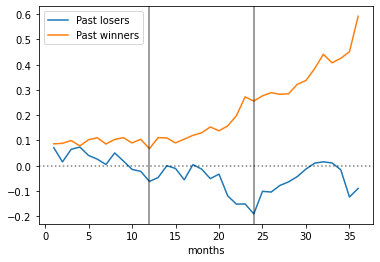

In [62]:
ax = bottom_portfolio_ret.groupby('months')['exret'].mean().plot(label='Past losers')
top_portfolio_ret.groupby('months')['exret'].mean().plot(ax=ax, label='Past winners')
ax.legend()
ax.axhline(y=0,  color='black', alpha=0.5, linestyle=':')
ax.axvline(x=12, color='black', alpha=0.5, linestyle='-')
ax.axvline(x=24, color='black', alpha=0.5, linestyle='-')

# Conclusion
Based on the recent empirical results (2009-2020), we can conclude that the Debondt and Thaler (1985) findings do not hold true in the recent years. The winner portfolio outperforms the loser portfolio in every observed timeframe.

<a id="section-six"></a>
# 6. REFERENCES

De BONDT, W.F.M. and THALER, R. (1985), Does the Stock Market Overreact?. The Journal of Finance, 40: 793-805. doi:10.1111/j.1540-6261.1985.tb05004.x

This notebook is adapted from code written by [Charles Martineau](http://www.charlesmartineau.com/), the University of Toronto and [Vincent Grégoire](http://www.vincentgregoire.com), Department of Finance, The University of Melbourne. 
